In [1]:
import json
import sys
sys.path.append("..")
from collections import defaultdict, Counter, namedtuple

import pathlib
import numpy as np 
import tensorflow as tf
from pathlib import Path
from src.dnn.loaders.VARdataloader import DataLoaderVAR as DataLoader

PATH_EXP = "/data/bacteria/experiments/autoencoders/6mer/27122023-5"

2024-01-01 22:17:02.068934: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 22:17:02.189024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
encoder = tf.keras.models.load_model(f"{PATH_EXP}/models/encoder.keras")
decoder = tf.keras.models.load_model(f"{PATH_EXP}/models/decoder.keras")
# autoencoder = tf.keras.models.load_model(f"{PATH_EXP}/checkpoints/weights-CNNAutoencoderCAEBN.keras")

In [3]:
list_fcgr = list(Path("/data/bacteria/experiments/autoencoders/6mer/fcgr").rglob("*/*.npy"))

paths_by_specie=defaultdict(list)
for path in list_fcgr:
    specie=path.parent.stem.split("__")[0]
    paths_by_specie[specie].append(path)

# Generate embedding for two assemblies

In [4]:
[p for p in  list(paths_by_specie.keys()) if "bacillus" in p ] 

['actinobacillus_pleuropneumoniae',
 'bacillus_subtilis',
 'bacillus_cereus',
 'bacillus_thuringiensis',
 'lactobacillus_plantarum',
 'paenibacillus_larvae',
 'lactobacillus_rhamnosus',
 'lactobacillus_salivarius',
 'bacillus_anthracis',
 'lactobacillus_casei']

In [5]:
specie1 = "chlamydia_trachomatis"
specie2 = "mycobacterium_ulcerans"
path_asm1 = paths_by_specie[specie1][0]
path_asm2 = paths_by_specie[specie2][0]

In [6]:
path_asm2

PosixPath('/data/bacteria/experiments/autoencoders/6mer/fcgr/mycobacterium_ulcerans__01/SAMN04538588.npy')

In [7]:
# preprocessing of each FCGR to feed the model 
preprocessing = lambda x: x / x.max() 

# compute embeddings
data_batches = DataLoader(
    list_paths=[path_asm1, path_asm2],
    batch_size=2,
    shuffle=False,
    preprocessing=preprocessing,
    inference_mode=True
)

In [8]:
n_interpolations=30

for batch in iter(data_batches):
    emb = encoder(batch)

interpolate_vecs = [ emb[0]*(1-l) + emb[1]*l for l in np.linspace(0,1,n_interpolations+2)]

output_decoder = decoder(tf.stack(interpolate_vecs))
output_decoder = tf.squeeze(output_decoder,axis=-1)


In [12]:
ncols = 5
nrows = int(len(output_decoder) / ncols) + 1   

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from complexcgr import FCGR

fcgr=FCGR(6)


In [36]:
img_orig = batch[0].squeeze(-1)
img_dest = batch[1].squeeze(-1)

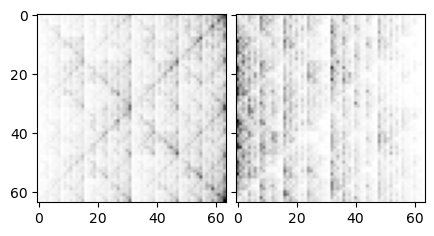

In [38]:
fig = plt.figure(1,(5,5))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.1,
                 )

grid[0].imshow(fcgr.plot(img_orig),"gray") 
grid[1].imshow(fcgr.plot(img_dest),"gray") 

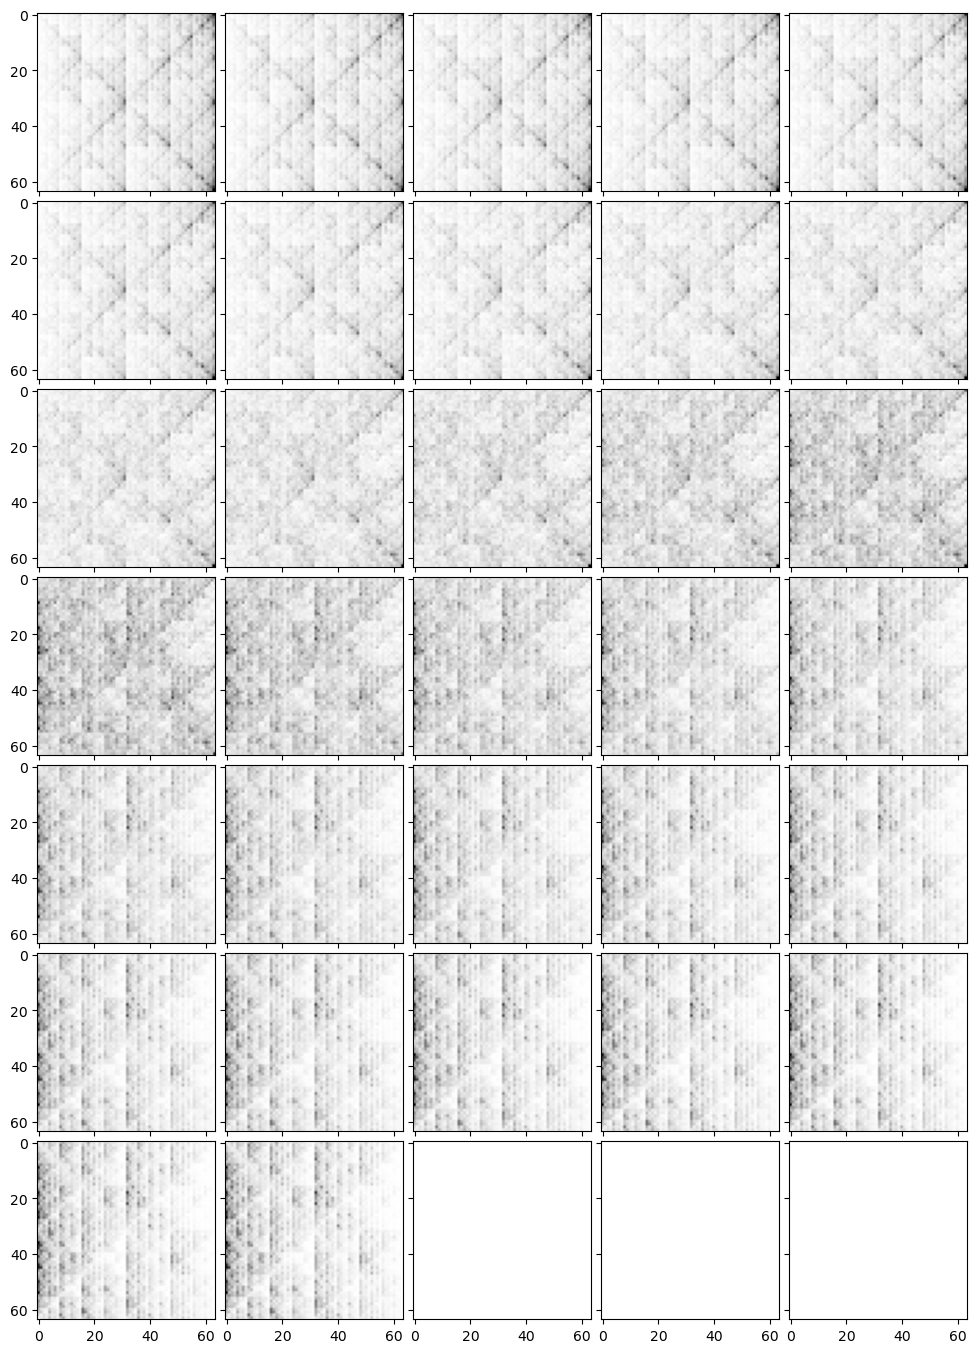

In [18]:
fig = plt.figure(1,(12,20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(nrows,ncols),
                 axes_pad=0.1,
                 )

for j, inp in enumerate(output_decoder.numpy()):
    grid[j].imshow(fcgr.plot(inp),'gray',)
    